<a href="https://colab.research.google.com/github/schauppi/Udemy_TensorFlow_Developer/blob/main/Abschnitt_8_NLP_fundamentals_in_TensorFlow/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (text or speech sequences).

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## check for GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-f2012935-cb4f-07c8-5929-08abf301b4f4)


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-13 11:13:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-13 11:13:32 (68.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Get a text dataset

The dataset we´re going to be using is Kaggle´s introduction to BLP dataset (text samples of Tweets labelled as disaster or nor disaster)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
unzip_data("nlp_getting_started.zip")

--2021-08-13 11:13:34--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-08-13 11:13:34 (99.0 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset 

To visualize our text samples, we first have to read them in, one way to do so would be to use Python.

Another way to do this is to use pandas...

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df["text"][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [7]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
#What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [11]:
# Let´s visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) #create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@local_arsonist LMFAO

---

Target: 0 (not real disaster)
Text:
genuine Leather man Bag Messenger fit iPad mini 4 tablet case cross body air jp - Full reaÛ_ http://t.co/rcBurZSb2b http://t.co/eHsfKlgRI3

---

Target: 0 (not real disaster)
Text:
@spinningbot Are you another Stand-user? If you are I will have to detonate you with my Killer Queen.

---

Target: 1 (real disaster)
Text:
'@jorrynja: 6. @ your bf/gf/crush ??' @Ter_ell ??

---

Target: 0 (not real disaster)
Text:
@nprfreshair I really can't believe he is skipping out before the Republican meltdown...I mean 'debate'.

---



### Split data into training and validation sets

In [12]:
from sklearn.model_selection import train_test_split

#Use train_test_split to split train data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [13]:
#Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
#Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Convert text into numbers

When dealing with a text problem, one of the first things you´ll have to do before you can build a model is to convert your text to numbers.

There are a few ways you can to this, namely:
* Tokenization - direct mapping of token (a token could be a word or character to number)
* Embedding - create a matrix of a feature vector for each token (the size of the feature vector can be defined and this embedding can be learned)

## Text vectorization (tokenization)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, #how man word in the vocabulary (automatically adds <OOV>)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, #create groups of n-words
                                    output_mode="int", #how to map tokens to numbers
                                    output_sequence_length=None, #how long the sequences should be
                                    pad_to_max_tokens=True)

In [16]:
train_sentences[0].split()

['@mogacola', '@zamtriossu', 'i', 'screamed', 'after', 'hitting', 'tweet']

In [17]:
len(train_sentences[0].split())

7

In [18]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [19]:
#Setup vectorizeation variables
max_vocab_length = 10000 #max number of words to have in our vocabulary
max_length = 15 #max length our sequences will be (e.g. how many words from a tweet will our model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [20]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [21]:
#Create a sample sentence and tokenize it
sample_sentence = "There´s a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  1,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [22]:
# choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence} \
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 Dr Jack Stern Interview Ending Back Pain for #Military #Injury. Listen now: http://t.co/YhH7X0MAio       

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1417, 2078, 8087, 2081, 3888,   88,  880,   10,  223,  345, 1007,
          48,    1,    0,    0]])>

In [23]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] #get the most common words
bottom_5_words = words_in_vocab[-5:] #get the least common words
print(len(words_in_vocab)) 
print(top_5_words)
print(bottom_5_words)

10000
['', '[UNK]', 'the', 'a', 'in']
['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we´re going to use TensorFlow´s embedding layer.

The parameters we care most about for our embedding layer:
* input_dim = the size of the vocabulary
* output_dim = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* input_length = length of the sequences being passed to the embedding layer

In [24]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

In [25]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text: \n {random_sentence} \
      \n\nEmbedded version")
#Embed the random sentence
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text: 
 Vanessa's game has officially blown up. LADIES AND GENTLEMEN...the real show is about to begin. #BB17       

Embedded version


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 6.66125864e-03, -2.98350211e-02,  3.65257598e-02, ...,
         -4.87753525e-02, -3.40015814e-03,  1.16229057e-05],
        [ 4.21171896e-02, -1.70164108e-02, -1.87242031e-02, ...,
          1.51018016e-02, -4.12915722e-02, -1.39283650e-02],
        [ 4.38256748e-02,  3.53414752e-02,  2.08260156e-02, ...,
          6.37527555e-03, -6.73494488e-03, -4.09466401e-02],
        ...,
        [ 3.88208665e-02,  4.99358661e-02, -1.93678029e-02, ...,
         -2.61671897e-02, -2.61265524e-02, -1.93732735e-02],
        [-4.19643745e-02, -3.61875892e-02, -4.96817753e-03, ...,
         -1.16875544e-02, -4.52664606e-02, -1.23867765e-02],
        [ 4.81318682e-04, -4.36109677e-02,  1.03690140e-02, ...,
          4.86134924e-02,  3.50689888e-03, -4.56969403e-02]]],
      dtype=float32)>

In [26]:
# Check out a single token´s embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 6.66125864e-03, -2.98350211e-02,  3.65257598e-02, -4.46803235e-02,
         4.55159284e-02,  2.82122158e-02, -3.11037786e-02,  2.48227268e-03,
         2.46642493e-02, -6.99120760e-03,  1.60386600e-02, -2.79510971e-02,
         1.60665847e-02, -9.21041891e-03,  3.69334333e-02, -1.55803673e-02,
        -3.87003049e-02,  3.30946594e-03, -5.87589666e-03,  4.96951602e-02,
         3.59697677e-02, -2.85660382e-02, -1.25174634e-02, -4.94587198e-02,
        -4.95067500e-02,  3.44072655e-03, -2.53215563e-02,  1.00279078e-02,
         2.35773623e-04, -4.95761521e-02,  2.09914520e-03, -1.48406625e-02,
         2.43741311e-02,  2.08774470e-02, -1.84725598e-03, -5.26286289e-03,
        -3.85593064e-02,  3.20249833e-02,  1.31303780e-02, -1.36679187e-02,
        -3.80614884e-02, -2.60225888e-02, -3.17508951e-02,  1.51429512e-02,
        -4.36469167e-03,  2.51559950e-02, -2.77943853e-02,  3.76496799e-02,
        -3.49988341e-02,  5.55696338e-0

## Modelling a text dataset (running a series of experiments)

Now we´ve got a way to turn our text sequences into numbers, it´s time to start building a series of modelling experiments.

We´ll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM
* Model 3: GRU
* Model 4: Bidirectional LSTM
* Model 5: 1D Convolution NN
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

How are we goint to approach all of these?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a model
* Fit the model
* Evaluate the model

### Model 0: Getting a baseline

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create tokenization and modellin pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), #cobvert words to numbers
                    ("clf", MultinomialNB()) #model the text
])

#Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [28]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [29]:
#Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

In [30]:
#Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 scroe of a binary classification model.
  """
  #Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  #Calculate model precision, racall and f1-scroe using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results

In [31]:
#Get baseline results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A simple dense model

In [32]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) #inputs are 1-dimensional strings
x = text_vectorizer(inputs) #turn the input text into numbers
x = embedding(x) #create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) #create the feature vector for each token
outputs = layers.Dense(1, activation="sigmoid")(x) #Create the binary output
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compile model
model_1.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [36]:
#Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20210813-111344
Epoch 1/5
215/215 [==============================] - 7s 19ms/step - loss: 0.6126 - accuracy: 0.6866 - val_loss: 0.5358 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4428 - accuracy: 0.8165 - val_loss: 0.4695 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3478 - accuracy: 0.8608 - val_loss: 0.4575 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2849 - accuracy: 0.8923 - val_loss: 0.4684 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2375 - accuracy: 0.9124 - val_loss: 0.4775 - val_accuracy: 0.7808


In [37]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4775 - accuracy: 0.7808


[0.4775243103504181, 0.7808399200439453]

In [38]:
#Make some predictions and evaluate those
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs.shape

(762, 1)

In [39]:
#look at a single prediction
model_1_preds_probs[0]

array([0.4048388], dtype=float32)

In [40]:
#look at the first 10 predictions
model_1_preds_probs[:10]

array([[0.4048388 ],
       [0.7695626 ],
       [0.99746215],
       [0.12760496],
       [0.11899138],
       [0.95040905],
       [0.92301553],
       [0.9933141 ],
       [0.9693572 ],
       [0.28719994]], dtype=float32)

In [41]:
#Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [42]:
# Calculate our model_1 results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'accuracy': 78.08398950131233,
 'f1': 0.778533312750939,
 'precision': 0.7834583238190046,
 'recall': 0.7808398950131233}

In [43]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [44]:
# Get the vocabulary from the text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [45]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Get weight matrix of embedding layer
#these are the numerical representations of each token in our training data
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) #same size as vocav size and embedding dim

(10000, 128)


To visualize, TensorFlow has a handy tool calles projector : https://projector.tensorflow.org/

In [48]:
#Create embedding files

import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [49]:
#Download files from colab to upload to projector
"""
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass
"""

"\ntry:\n  from google.colab import files\n  files.download('vectors.tsv')\n  files.download('metadata.tsv')\nexcept Exception:\n  pass\n"

## Recurrent Neural Networks (RNN´s)

The premise of a RNN is to use the representation of a previous input to aid the representation of the later input.

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typicall looks like this:

Input (text) - Tokenize - Embedding - Layers (RNN/dense) - Output (label probability)

In [50]:
#Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x) #when you´re stacking RNN cells together, you need to set return_sequences=True
x = layers.LSTM(64, return_sequences=False)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [51]:
#Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [52]:
#Compile the model
model_2.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [53]:
#Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20210813-111443
Epoch 1/5
215/215 [==============================] - 10s 25ms/step - loss: 0.2231 - accuracy: 0.9228 - val_loss: 0.5252 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1562 - accuracy: 0.9422 - val_loss: 0.6286 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1290 - accuracy: 0.9514 - val_loss: 0.7060 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1060 - accuracy: 0.9609 - val_loss: 0.9409 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 4s 21ms/step - loss: 0.0853 - accuracy: 0.9664 - val_loss: 0.8948 - val_accuracy: 0.7703


In [54]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[2.6227957e-02],
       [8.4380090e-01],
       [9.9958009e-01],
       [9.1228284e-02],
       [9.9043292e-04],
       [9.9888378e-01],
       [9.1179442e-01],
       [9.9983943e-01],
       [9.9974149e-01],
       [7.1121746e-01]], dtype=float32)

In [55]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
#Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 77.03412073490814,
 'f1': 0.7696090403305004,
 'precision': 0.7700604729059295,
 'recall': 0.7703412073490814}

In [57]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [58]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=False)(x)
#x = layers.LSTM(64)(x)
#x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [59]:
#get model summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [60]:
#Compile the model
model_3.compile(loss="binary_crossentropy", optimizer="Adam", metrics="accuracy")

In [61]:
#Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20210813-111527
Epoch 1/5
215/215 [==============================] - 7s 24ms/step - loss: 0.1598 - accuracy: 0.9380 - val_loss: 0.7754 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0831 - accuracy: 0.9705 - val_loss: 0.9894 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0703 - accuracy: 0.9734 - val_loss: 0.7712 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0564 - accuracy: 0.9764 - val_loss: 1.1602 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0524 - accuracy: 0.9777 - val_loss: 1.0935 - val_accuracy: 0.7717


In [62]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[3.8109135e-03],
       [8.2190216e-01],
       [9.9985743e-01],
       [1.6226959e-01],
       [9.1455091e-05],
       [9.9901402e-01],
       [4.2244706e-01],
       [9.9992287e-01],
       [9.9982738e-01],
       [6.3797808e-01]], dtype=float32)

In [63]:
#Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [64]:
#Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 77.16535433070865,
 'f1': 0.7693184984034235,
 'precision': 0.7738402637184817,
 'recall': 0.7716535433070866}

### Model 4: Bidirectional RNN

Normal RNN´s go from left to right (just like you´d read an english sentence) however, a bidirectional RNN goes from right to left as well as from right to left.

In [65]:
# Build a bidirectional RNN in tensorflow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [66]:
#Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [67]:
#Compile the model
model_4.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [68]:
#Fit the model
model_4_history = model_4.fit(train_sentences, 
                              train_labels, 
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20210813-111612
Epoch 1/5
215/215 [==============================] - 10s 31ms/step - loss: 0.1083 - accuracy: 0.9691 - val_loss: 0.9647 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0536 - accuracy: 0.9768 - val_loss: 1.1117 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0472 - accuracy: 0.9794 - val_loss: 1.2219 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0407 - accuracy: 0.9818 - val_loss: 1.4722 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0395 - accuracy: 0.9804 - val_loss: 1.5014 - val_accuracy: 0.7585


In [69]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[3.8165267e-04],
       [9.7477210e-01],
       [9.9998236e-01],
       [1.7153399e-01],
       [1.8366243e-05],
       [9.9964702e-01],
       [9.3600929e-01],
       [9.9998891e-01],
       [9.9998307e-01],
       [9.9870253e-01]], dtype=float32)

In [70]:
#Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [71]:
#calculate the result of our bidirectional model
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 75.8530183727034,
 'f1': 0.75741871177066,
 'precision': 0.7583857376990771,
 'recall': 0.7585301837270341}

## Convolution Neural Networks for Text (and other types of sequences)

We´ve used CNNs for images but images are typically 2D (height x width)... however, out text data is 1D.

Previously we´ve used Conv2D for our image data but now we´re going to use Conv1D.

The typical structure of a Conv1D model for sequences (in out case, text):

Inputs (text) -> Tokenization -> Embedding -> Layers (Conv1D + Pooling) -> Outputs (class probabilities)

### Model 5: Conv1D

For different explanations of parameter see:
* CNN explainer (this is for 2D but can relate to 1D)
* Difference between same and valid - Google

In [146]:
# Test out out embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) #turn target into embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, #looks at 5 words at a time
                        activation="relu",
                        padding="valid") # deafult = "valid", the output is smaller than the input shape

conv_1d_output = conv_1d(embedding_test) #pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) #get the most important features - features with highest values

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [147]:
#embedding_test

In [148]:
#conv_1d_output

In [149]:
#max_pool_output

In [150]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation="relu",
                  padding="valid",
                  strides=1)(x)
x = layers.GlobalMaxPooling1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [151]:
#Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer="Adam", 
                metrics=["accuracy"])

In [152]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [153]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210813-121756
Epoch 1/5
215/215 [==============================] - 7s 29ms/step - loss: 0.0929 - accuracy: 0.9691 - val_loss: 1.0477 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.0557 - accuracy: 0.9781 - val_loss: 1.1333 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0493 - accuracy: 0.9800 - val_loss: 1.2603 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0468 - accuracy: 0.9800 - val_loss: 1.3464 - val_accuracy: 0.7585
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0462 - accuracy: 0.9804 - val_loss: 1.3092 - val_accuracy: 0.7493


In [154]:
# Make some predictions
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[3.7684690e-02],
       [8.0398560e-01],
       [9.9994183e-01],
       [6.5927662e-02],
       [2.2011969e-08],
       [9.9366719e-01],
       [9.7688705e-01],
       [9.9995995e-01],
       [9.9999976e-01],
       [8.2744163e-01]], dtype=float32)

In [155]:
#Convert pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [156]:
#Evaluate predictions
model_5_results = calculate_results(val_labels,
                                    model_5_preds)
model_5_results

{'accuracy': 74.93438320209974,
 'f1': 0.7475418608650599,
 'precision': 0.7497485948057045,
 'recall': 0.7493438320209974}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we´ve build a few of our own models, let´s try and use transfer learning for NLP, specifically using TensorFlow Hub´s pretrained Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

In [157]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["sample sentence", "When you call the universal sentence encoder, it turns it into number"])
embed_samples[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([-0.03938255,  0.00283756,  0.02243922,  0.0245115 , -0.04985989,
        0.05275185,  0.01906133,  0.03593649, -0.04484411,  0.01787181,
       -0.03389932, -0.00872529, -0.02777038,  0.09363514, -0.02399772,
       -0.08983202, -0.03871281,  0.00450141, -0.02363318, -0.03881208,
       -0.01647638,  0.04881011, -0.00920218,  0.05666861, -0.06821936,
        0.06926924, -0.01130831, -0.0776007 ,  0.00864499, -0.02895822,
        0.00346943,  0.01833375, -0.06229274,  0.02653736, -0.09129825,
        0.02586216, -0.00045973,  0.03273476, -0.06651258,  0.03915777,
       -0.03467299,  0.0575624 , -0.00661325, -0.01383738, -0.04131497,
       -0.02762501,  0.04249629, -0.00791721,  0.04456056, -0.01393928],
      dtype=float32)>

In [158]:
embed_samples[0].shape

TensorShape([512])

In [159]:
# Create a Keras Layers using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], #because input can be of variable length
                                        dtype=tf.string, trainable=False, name="USE")

In [160]:
# Build the model

model_6 = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64, activation="relu"),
                               layers.Dense(1, activation="sigmoid")
                               
], name="model_6_USE")

In [161]:
#Compile the model
model_6.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [162]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [163]:
# Fit the model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210813-121826
Epoch 1/5
215/215 [==============================] - 9s 30ms/step - loss: 0.5032 - accuracy: 0.7865 - val_loss: 0.4491 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4136 - accuracy: 0.8143 - val_loss: 0.4379 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4023 - accuracy: 0.8212 - val_loss: 0.4330 - val_accuracy: 0.8097
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3924 - accuracy: 0.8270 - val_loss: 0.4315 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3852 - accuracy: 0.8301 - val_loss: 0.4263 - val_accuracy: 0.8150


In [164]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19021057],
       [0.79055303],
       [0.98817295],
       [0.21221776],
       [0.6921382 ],
       [0.7400054 ],
       [0.98064226],
       [0.97764313],
       [0.9448513 ],
       [0.088572  ]], dtype=float32)

In [165]:
#Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [166]:
#Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8134357776936025,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598}

In [167]:
len(train_sentences)

6851

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning helps when you don´t have a large dataset.
To see how our model performs on a smaller dataset, let´s replicate model_6 except we´ll train it on 10% of the data.

In [168]:
## DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET 

"""
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
"""

'\n# Create subsets of 10% of the training data\ntrain_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)\ntrain_sentences_10_percent = train_10_percent["text"].to_list()\ntrain_labels_10_percent = train_10_percent["target"].to_list()\n'

In [169]:
#Making a bestter dataset split
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [170]:
len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [171]:
#Check the number of targets in our subset of data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [172]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model same to a previous model you´ve created you can use the tf.keras.models.clone_model() method 

In [173]:
#Build the model - same as model_6

model_7 = tf.keras.models.clone_model(model_6)

In [174]:
# Compile the model
model_7.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [175]:
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [176]:
#Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20210813-121857
Epoch 1/5
22/22 [==============================] - 6s 138ms/step - loss: 0.6723 - accuracy: 0.6599 - val_loss: 0.6479 - val_accuracy: 0.7651
Epoch 2/5
22/22 [==============================] - 1s 30ms/step - loss: 0.5989 - accuracy: 0.8161 - val_loss: 0.5897 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 1s 45ms/step - loss: 0.5239 - accuracy: 0.8219 - val_loss: 0.5362 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 1s 31ms/step - loss: 0.4660 - accuracy: 0.8248 - val_loss: 0.5067 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 1s 31ms/step - loss: 0.4260 - accuracy: 0.8350 - val_loss: 0.4912 - val_accuracy: 0.7690


In [177]:
# Make predictions 
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.2169291 ],
       [0.5463702 ],
       [0.92180216],
       [0.37913105],
       [0.52620935],
       [0.70240134],
       [0.9078629 ],
       [0.8184258 ],
       [0.86326647],
       [0.17640129]], dtype=float32)

In [178]:
#turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [179]:
#Evaluate predictions
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 76.9028871391076,
 'f1': 0.7674269881907728,
 'precision': 0.7697342660172047,
 'recall': 0.7690288713910761}

## Comparing the performance of each of our models

In [180]:
# combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                 "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [181]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.780840,0.783458,0.780840,0.778533
2_lstm,0.770341,0.770060,0.770341,0.769609
3_gru,0.771654,0.773840,0.771654,0.769318
4_bidirectional,0.758530,0.758386,0.758530,0.757419
5_conv1d,0.749344,0.749749,0.749344,0.747542
6_tf_hub_use_encoder,0.814961,0.817255,0.814961,0.813436
7_tf_hub_use_encoder_10_percent,0.769029,0.769734,0.769029,0.767427


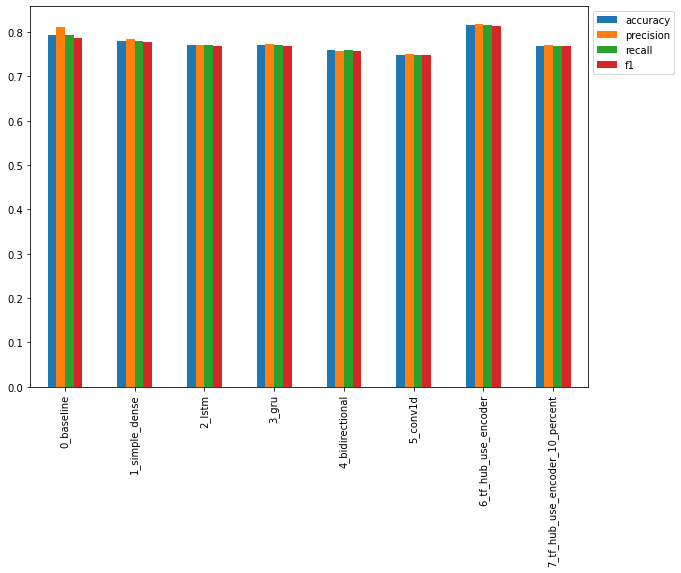

In [182]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

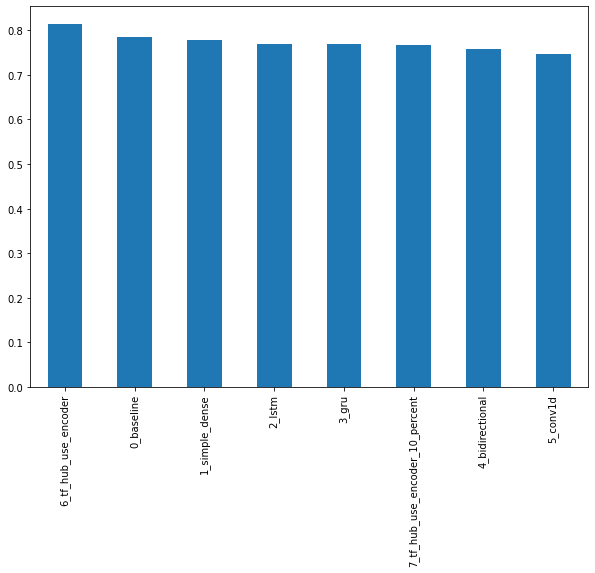

In [183]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Uploading model training logs to TensorBoard.dev

In [184]:
#View TensorBoard logs of transfer learning modelling experiment (plus all of our other models)
#Upload TensorBoard dev records

"""
!tensorboard dev upload --logdir ./model_logs/ \
--name "NLP Modelling Experiments ZTM TF Course Video" \
--description "Comparing multiple different types of model architectures on the Kaggle Tweets classification Dataset" \
--one_shot #exit the uploader once uploading is finished
"""

'\n!tensorboard dev upload --logdir ./model_logs/ --name "NLP Modelling Experiments ZTM TF Course Video" --description "Comparing multiple different types of model architectures on the Kaggle Tweets classification Dataset" --one_shot #exit the uploader once uploading is finished\n'

In [185]:
#!tensorboard dev list

In [186]:
# If you need to delete an experiment from TensorBoard, you can run the following
#!tensorboard dev delete --experiment_id wjXPNKqBTnGGcDnP3FObkg

## Saving and loading a trained model

There are two main formats to save a model in TensorFlow
1. The HDF5 format
2. The SavedModel format (default)

In [187]:
#Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [188]:
# Load model with costum Hub Layer (required HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [189]:
# How does our loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4263 - accuracy: 0.8150


[0.426333487033844, 0.8149606585502625]

In [190]:
#Save to SavedModel format
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [191]:
#Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [192]:
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4263 - accuracy: 0.8150


[0.426333487033844, 0.8149606585502625]

## Finding the most wrong examples

* If our best model still isn´t perfect, what examples is it getting wrong?
* And of these wrong examples which ones is getting most wrong (those will prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a predictions probability of 0.999 (relly close to 1) and vice versa.

In [193]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-08-13 12:29:55--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.187.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   113MB/s    in 8.4s    

2021-08-13 12:30:04 (109 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.in

In [194]:
#Import model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [197]:
#Make predictions with the loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [202]:
#Create DataFrame with validation sentences, validation labels and best performing model predictions labels + probabilities
val_df = pd.DataFrame({"test": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df

,test,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.137074
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.095865
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
760,Crack in the path where I wiped out this morni...,0,1.0,0.612631


In [208]:
#Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] #these are the false positives

,test,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [209]:
most_wrong.tail() #these are the false negatives

,test,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Target labels
* 0 = no disaster
* 1 = disaster

In [213]:
#Check the false positives (model predicted 1 when should´ve been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("------\n")

Target: 0, Pred 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

------

Target: 0, Pred 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

------

Target: 0, Pred 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

------

Target: 0, Pred 1.0, Prob: 0.8354544639587402
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

------

Target: 0, Pred 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

------

Target: 0, Pred 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!



In [214]:
#Check the false negatives (model predicted 0 when should´ve been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("------\n")

Target: 1, Pred 0.0, Prob: 0.06730344146490097
Text:
@DavidVonderhaar At least you were sincere ??

------

Target: 1, Pred 0.0, Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

------

Target: 1, Pred 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

------

Target: 1, Pred 0.0, Prob: 0.05459698289632797
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

------

Target: 1, Pred 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

------

Target: 1, Pred 0.0, Prob: 0.04391850158572197
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

------

Target: 1, Pred 0.0, Prob

## Making predictions on the test dataset 

In [217]:
#Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) #our model expects a list as input
  pred = tf.round(pred_prob)£
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 1, Prob: 0.7029712796211243
Text:
@MarcVegan @NonDairyKerry true. Also takes 16000 gal water to produce 1 lb hamburger. Drought in Midwest will be chaos

-----

Pred: 0, Prob: 0.36263951659202576
Text:
Still wonder why they will do anything to have a life anywhere. Wars u support CAUSE refugees open boarders. #auspol https://t.co/3MjtE74AiW

-----

Pred: 0, Prob: 0.23200277984142303
Text:
@thehill this is 1 example of y the Conservatives annihilated Burton v Wiimington Prkng Auth while Liberals stood by &amp;have done nothing

-----

Pred: 0, Prob: 0.031225766986608505
Text:
@CazorlaPlay Fran. Hey check out the Secret on how to get 325.000 Riot Points LoL Check it on my Bio Profile

-----

Pred: 0, Prob: 0.04568731412291527
Text:
BANG 3 Fuckin phenomenal

-----

Pred: 1, Prob: 0.7229545712471008
Text:
Job event targets displaced Double 8 employees http://t.co/2SJaaDRYdc http://t.co/RovTa5EUQO

-----

Pred: 1, Prob: 0.6035112142562866
Text:
Any other generation this would've been 

## The speed/score tradeoff

In [218]:
# Let´s make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() #get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time #calculate how long predictions time to make
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [219]:
#Calculate TF Hub Sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6_pretrained, val_sentences)

In [220]:
model_6_time_per_pred, model_6_total_pred_time

(0.00044559181627264096, 0.3395409639997524)

In [221]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_pred_pred = pred_timer(model_0, val_sentences)

In [222]:
baseline_total_pred_time, baseline_time_pred_pred

(0.02031149600043136, 2.665550656224588e-05)

In [223]:
#get results for pretrained GS model
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.49606299212599,
 'f1': 0.8134357776936025,
 'precision': 0.8172549323109193,
 'recall': 0.8149606299212598}

Text(0, 0.5, 'F1-score')

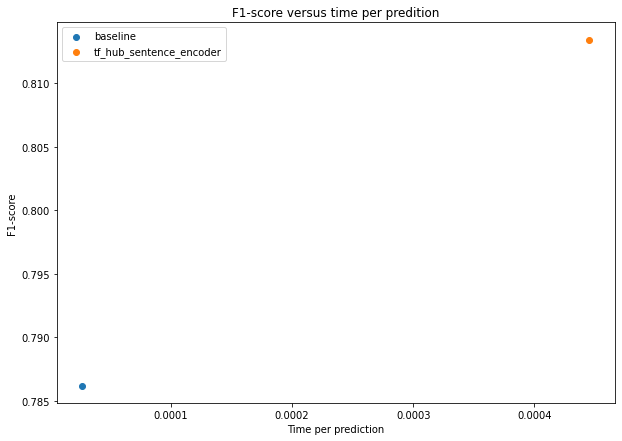

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(baseline_time_pred_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per predition")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")